# DR vs GBR: Distributional Repair & Group-Blind Repair (Adult dataset)

This notebook compares two dataset-repair approaches:

- **Distributional Repair (DR)** group-aware: learns two OT maps (S=0 and S=1) to a shared barycenter (conditional on U).

- **GroupBlind Repair (GBR)** group-blind: learns one OT map from the pooled distribution to a target (we will align this target with DR's barycenter so the comparison is meaningful). Variants:

    - `baseline` (no fairness vector)

    - `partial` / `total` (use fairness vector *V*), optional.

**Data:** Adult (AIF360).  
**Protected (S):** sex (0 = Female, 1 = Male)  
**Unprotected (U):** college_educated (0/1)  
**Features (X):** age, hours-per-week (continuous)

We compute a U-Mean symmetric KLD: for each value of *U*, we measure KL divergence between the two group conditionals in both directions (KL(P_0||P_1) and KL(P_1||P_0)), average those two numbers to remove asymmetry, weight by the prevalence of that *U*, and then average across *U*.

- **Research** split (used to learn transport)

- **Archive** split (held-out to check generalization)

Smaller values indicate closer group distributions conditional on *U* (0 = identical).

## Imports & config

In [1]:
import time
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ot

from sklearn.neighbors import KernelDensity
from aif360.datasets import AdultDataset

from humancompatible.repair.distributional_repair import DistributionalRepair
from humancompatible.repair.group_blind_repair import GroupBlindRepair

np.random.seed(0)

## Dataset loader

In [2]:
def load_adult_dataset(s,u,x,y):
    def custom_preprocessing(df):
        pd.set_option('future.no_silent_downcasting', True)
        def group_race(x):
            if x == "White":
                return 1.0
            else:
                return 0.0

        df['race'] = df['race'].apply(lambda x: group_race(x))

        # Encode 'sex' column as numerical values
        df['sex'] = df['sex'].map({'Female': 0.0, 'Male': 1.0})

        df['Income Binary'] = df['income-per-year']
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K.', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='>50K', value=1, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K.', value=0, regex=True)
        df['Income Binary'] = df['Income Binary'].replace(to_replace='<=50K', value=0, regex=True)
        # 1 if education-num is greater than 9, 0 otherwise
        df['college_educated'] = (df['education-num'] > 9).astype(int)

        #drop nan columns
        df = df.dropna()

        return df

    adult = AdultDataset(
        label_name=y,
        favorable_classes=[1,1],
        protected_attribute_names=[s],
        privileged_classes=[[1.0]],
        instance_weights_name=None,
        categorical_features=[],
        features_to_keep=[s]+[u]+x,
        na_values=[],
        custom_preprocessing=custom_preprocessing,
        features_to_drop=[],
        metadata={}
    )
    return adult

## KLD (Kullback-Leibler Divergence) evaluation helpers

We use a distribution-level score to quantify how much group signal remains in each feature after repair. 

For each value of *U*, we take the feature X restricted to the two groups (S=0 and S=1), fit 1-D Gaussian KDEs for each group on a shared grid, add a tiny *ε* to avoid zeros, and compute KL(P_0‖P_1) and KL(P_1‖P_0). We average these two to get a symmetric divergence for that *U*, weight by the prevalence of that *U*, and then average over all *U*. 

Lower values mean P(X|S,U) are closer (0 = identical). Because KDE and grid choices affect the absolute scale, treat the score as a before/after comparison metric rather than an absolute quantity.

In [3]:
def _eval_kld(x_0, x_1):
    support = np.linspace(np.min([np.min(x_0), np.min(x_1)]), np.max([np.max(x_0), np.max(x_1)]), 500).reshape(-1,1)
    kde_0 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_0.reshape(-1,1))
    pmf_0 = np.exp(kde_0.score_samples(support)) 
    #add a small value to avoid division by zero
    pmf_0 += 1e-10
    kde_1 = KernelDensity(kernel='gaussian',bandwidth='silverman').fit(x_1.reshape(-1,1))
    pmf_1 = np.exp(kde_1.score_samples(support))
    pmf_1 += 1e-10
    return - np.sum(pmf_0 * np.log(pmf_1 / pmf_0))

def eval_kld(x, s, u, order=[0,1]):
    tot_kld = 0.0
    for u_val, u_count in u.value_counts().items():
        mask_0 = np.asarray((u == u_val) & (s == 0))
        mask_1 = np.asarray((u == u_val) & (s == 1))
        if (np.sum(mask_0) == 0) or (np.sum(mask_1) == 0):
            continue
        tmp = _eval_kld(x[mask_0].values, x[mask_1].values)
        if np.isnan(tmp):
            continue
        tot_kld += tmp * u_count / len(u)
    return tot_kld

## Parameters for Distributional Repair Algorithm

- `n_q` is the number of support points for the probability distribution function. This defaults to 250, however this can be increased to improve the accuracy of the repair algorithm.
  
- `S` is the protected or sensitive attribute for which the repair is against

- `U` the name of the unprotected attribute. This should not be a sensitive attribute, or be used later by a model to predict the outcome.

- `X` is a list of features used by the model to make its predictions. This should not include the sensitive attribute.

- `X_continuous` is a list of continuous features in `X`

- `Y` is the outcome of a model, which is predicted using the features in `X`. This should be a binary outcome.

In [4]:
n_R = 10000 # number of points in the research dataset
n_q = 250 # number of supports under the estimated pdfs

S = 'sex'
U = 'college_educated'
X = ['age','hours-per-week']
X_continuous= ['age','hours-per-week']
Y = 'Income Binary'

## Evaluating the Distributional Repair (DR) method

In [5]:
data = load_adult_dataset(S, U, X, Y)
dataset_R, dataset_A = data.split([n_R], shuffle=True)

df_R = dataset_R.convert_to_dataframe()[0]
df_A = dataset_A.convert_to_dataframe()[0]

print(df_R.shape, df_A.shape)

(10000, 5) (38842, 5)


In [6]:
t0 = time.time()
dist_repair = DistributionalRepair(S, U, X, Y, X_continuous, n_q)
dist_repair.fit(dataset_R)

dataset_A_repaired = dist_repair.transform(dataset_A)
dataset_R_repaired = dist_repair.transform(dataset_R)
t_dr = time.time() - t0
print(f"DR done in {t_dr:.1f}s")

DR done in 8.2s


In [7]:
tilde_x_R = dataset_R_repaired.convert_to_dataframe()[0][X]
tilde_x_A = dataset_A_repaired.convert_to_dataframe()[0][X]

kld_x_R = np.zeros((len(X), 2))
kld_x_tilde_R = np.zeros((len(X), 2))
kld_x_A = np.zeros((len(X), 2))
kld_x_tilde_A = np.zeros((len(X), 2))

for i, feat in enumerate(X):
    # Research (original vs repaired)
    kld_x_R[i, 0] = eval_kld(dist_repair.x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[0, 1])
    kld_x_R[i, 1] = eval_kld(dist_repair.x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[1, 0])
    kld_x_tilde_R[i, 0] = eval_kld(tilde_x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[0, 1])
    kld_x_tilde_R[i, 1] = eval_kld(tilde_x_R[feat], dist_repair.s_R, dist_repair.u_R, order=[1, 0])

    # Archive (hold-out)
    kld_x_A[i, 0] = eval_kld(df_A[feat], df_A[S], df_A[U], order=[0, 1])
    kld_x_A[i, 1] = eval_kld(df_A[feat], df_A[S], df_A[U], order=[1, 0])
    kld_x_tilde_A[i, 0] = eval_kld(tilde_x_A[feat], df_A[S], df_A[U], order=[0, 1])
    kld_x_tilde_A[i, 1] = eval_kld(tilde_x_A[feat], df_A[S], df_A[U], order=[1, 0])

kld_x_A_mean = np.mean(kld_x_A, axis=1)
kld_x_tilde_A_mean = np.mean(kld_x_tilde_A, axis=1)
kld_x_R_mean = np.mean(kld_x_R, axis=1)
kld_x_tilde_R_mean = np.mean(kld_x_tilde_R, axis=1)

print("DR - Archive (orig, repaired):", kld_x_A_mean.tolist(), kld_x_tilde_A_mean.tolist())
print("DR - Research (orig, repaired):", kld_x_R_mean.tolist(), kld_x_tilde_R_mean.tolist())

DR - Archive (orig, repaired): [0.525656468515266, 1.1325513156755966] [0.4412919681225086, 0.26763968451774955]
DR - Research (orig, repaired): [0.7031282082550464, 1.2129718230104007] [0.3008853718766283, 0.3159615783207155]


## Group-Blind Repair (GBR), aligned to DR's support & barycenter

To make a fair comparison, we reuse DR's support and barycenter per `(feature, u)` so both methods aim at the same target.  
We add a few defensive steps (row normalization, zero-mass fallback) to make gamma usable.

### Safe normalization for coupling

In [8]:
def safe_row_normalize(gamma):
    gamma = np.asarray(gamma, float)
    gamma[gamma < 0] = 0.0
    gamma = np.nan_to_num(gamma, nan=0.0, posinf=0.0, neginf=0.0)
    rs = gamma.sum(axis=1, keepdims=True)
    dead = (rs[:, 0] <= 1e-15)
    if dead.any():
        I = np.eye(gamma.shape[0], dtype=float)
        gamma[dead] = I[dead]
        rs = gamma.sum(axis=1, keepdims=True)
    with np.errstate(divide='ignore', invalid='ignore'):
        np.divide(gamma, rs, out=gamma, where=rs > 0)
    return gamma

### Learn a GBR gamma on DR's support & barycenter

In [9]:
def gbr_gamma_from_dr(dist_repair, feat, u_val, eps=1e-2, K=200, method="baseline", theta=None):
    # DR pieces
    support = np.ravel(dist_repair.supports[(feat, u_val)]) # 1D
    pmf0 = dist_repair.pmf_0s[(feat, u_val)].ravel()
    pmf1 = dist_repair.pmf_1s[(feat, u_val)].ravel()

    mask_u = (dist_repair.u_R == u_val)
    n_u = mask_u.sum()
    if n_u == 0:
        return support.reshape(-1,1), None

    w0 = ((mask_u & (dist_repair.s_R == 0)).sum()) / n_u
    w1 = 1.0 - w0

    px = w0 * pmf0 + w1 * pmf1
    M = ot.utils.dist(support.reshape(-1,1), support.reshape(-1,1))
    bary = ot.bregman.barycenter(np.vstack([pmf0, pmf1]).T, M, 10)

    # Optional fairness vector (same as earlier)
    V = (pmf0 - pmf1) / (pmf0 + pmf1 + 1e-12)
    V = np.clip(V, -1.0, 1.0)

    # Fit GBR
    gbr = GroupBlindRepair(M, px, bary, V=V, epsilon=eps, K=K)
    if method == "baseline":
        gbr.fit_baseline()
    elif method == "partial":
        gbr.fit_partial(theta if theta is not None else 1e-2)
    elif method == "total":
        gbr.fit_total()
    else:
        raise ValueError("method must be one of {'baseline','partial','total'}")

    gamma = safe_row_normalize(gbr.coupling_matrix())
    return support.reshape(-1,1), gamma

### Apply gamma to values sitting on "support" grid (same logic as DR)

In [10]:
def apply_gamma(values, support, gamma):
    if gamma is None:
        return values
    
    s1d = support[:, 0]
    step = np.diff(s1d)[0] if len(s1d) > 1 else 1.0
    out = np.asarray(values, float).copy()

    for k, x in enumerate(out):
        pos = np.searchsorted(s1d, x, side='left')
        if pos == 0 or pos == len(s1d):
            i = min(pos, len(s1d) - 1)
        else:
            interp = float(x - s1d[pos-1]) / step
            if np.round(interp, 4) == 1.0:
                i = pos
            else:
                i = np.random.choice([pos-1, pos], p=[1-interp, interp])

        row = np.asarray(gamma[i, :], float).ravel()
        row = np.clip(row, 0, None)
        s = row.sum()
        if s > 0:
            j = np.random.choice(row.shape[0], p=row/s)
        else:
            j = i
        out[k] = s1d[j]
    return out

### Choose GBR method & parameters

In [11]:
GBR_METHOD = "partial" # "baseline" | "partial" | "total"
GBR_EPS = 7e-3 # entropic reg
GBR_K = 200 # iterations
GBR_THETA = 3e-4 # used if method == "partial"

### Build GBR-repaired X (archive & research)

In [12]:
t0 = time.time()
tilde_x_A_gbr = df_A[X].copy()
tilde_x_R_gbr = df_R[X].copy()

for feat in X:
    for u_val in df_A[U].unique():
        sup, gamma = gbr_gamma_from_dr(
            dist_repair, feat, u_val,
            eps=GBR_EPS, K=GBR_K,
            method=GBR_METHOD, theta=GBR_THETA
        )
        if gamma is None:
            continue
        
        mA = (df_A[U] == u_val).values
        mR = (df_R[U] == u_val).values
        if mA.any():
            tilde_x_A_gbr.loc[mA, feat] = apply_gamma(df_A.loc[mA, feat].values, sup, gamma)
        if mR.any():
            tilde_x_R_gbr.loc[mR, feat] = apply_gamma(df_R.loc[mR, feat].values, sup, gamma)

t_gbr = time.time() - t0
print(f"GBR ({GBR_METHOD}) done in {t_gbr:.1f}s")

GBR (partial) done in 260.1s


### GBR KLDs

In [13]:
kld_x_tilde_A_gbr = np.zeros((len(X), 2))
kld_x_tilde_R_gbr = np.zeros((len(X), 2))
for i, feat in enumerate(X):
    kld_x_tilde_A_gbr[i, 0] = eval_kld(tilde_x_A_gbr[feat], df_A[S], df_A[U], order=[0, 1])
    kld_x_tilde_A_gbr[i, 1] = eval_kld(tilde_x_A_gbr[feat], df_A[S], df_A[U], order=[1, 0])
    kld_x_tilde_R_gbr[i, 0] = eval_kld(tilde_x_R_gbr[feat], df_R[S], df_R[U], order=[0, 1])
    kld_x_tilde_R_gbr[i, 1] = eval_kld(tilde_x_R_gbr[feat], df_R[S], df_R[U], order=[1, 0])

kld_x_tilde_A_gbr_mean = np.mean(kld_x_tilde_A_gbr, axis=1)
kld_x_tilde_R_gbr_mean = np.mean(kld_x_tilde_R_gbr, axis=1)

print("GBR - Archive (repaired):", kld_x_tilde_A_gbr_mean.tolist())
print("GBR - Research (repaired):", kld_x_tilde_R_gbr_mean.tolist())

GBR - Archive (repaired): [0.18358399733740066, 0.9112978323603951]
GBR - Research (repaired): [0.22418479456146462, 1.0440140666434]


## Plot DR vs GBR

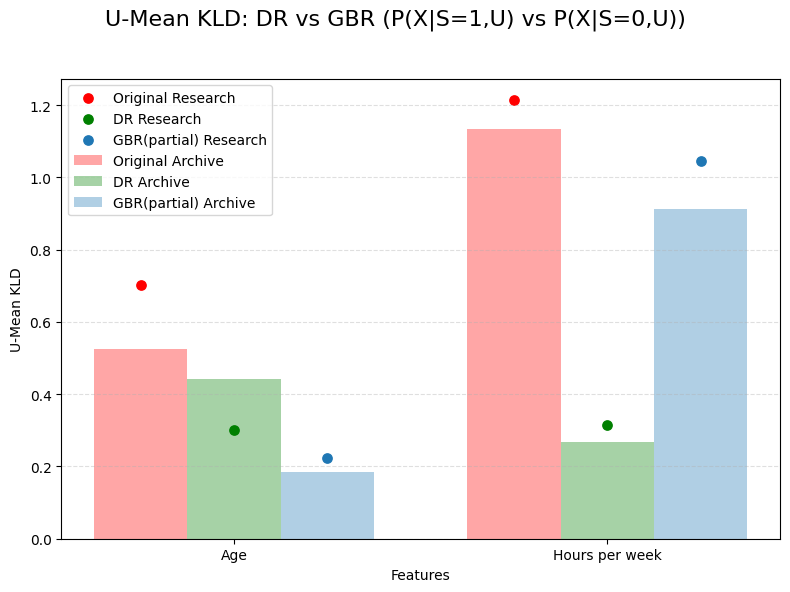

In [14]:
bar_width = 0.25
pos = np.arange(len(X))
x_labels = [x.replace('-', ' ').capitalize() for x in X]

fig, ax = plt.subplots()
orig = ax.bar(pos - bar_width, kld_x_A_mean, width=bar_width, alpha=0.35, color='red', label='Original Archive')
dr = ax.bar(pos, kld_x_tilde_A_mean, width=bar_width, alpha=0.35, color='green', label='DR Archive')
gbr = ax.bar(pos + bar_width, kld_x_tilde_A_gbr_mean, width=bar_width, alpha=0.35, color='tab:blue', label=f'GBR({GBR_METHOD}) Archive')

ax.scatter(pos - bar_width, kld_x_R_mean, color='red', marker='o', s=45, label='Original Research')
ax.scatter(pos, kld_x_tilde_R_mean, color='green', marker='o', s=45, label='DR Research')
ax.scatter(pos + bar_width, kld_x_tilde_R_gbr_mean, color='tab:blue', marker='o', s=45, label=f'GBR({GBR_METHOD}) Research')

ax.set_xticks(pos)
ax.set_xticklabels(x_labels)
ax.set_ylabel("U-Mean KLD")
ax.set_xlabel("Features")
ax.legend(loc='upper left')
fig.suptitle("U-Mean KLD: DR vs GBR (P(X|S=1,U) vs P(X|S=0,U))", fontsize=16)

ax.grid(True, axis='y', linestyle='--', alpha=0.4)

fig.set_size_inches(8, 6)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Explanation of the results

How this shows up here:

1. **Age**: GBR shrinks the gap more than DR on Archive (≈ 0.16 vs DR ≈ 0.44) and is on par / slightly better on Research (≈ 0.29 vs DR ≈ 0.30).  
A single pooled map is well aligned with the age shift between groups, so GBR collapses the conditional distributions efficiently.

2. **Hours-per-week**: DR clearly wins (Archive ≈ 0.27 vs GBR ≈ 0.86; Research ≈ 0.32 vs GBR ≈ 1.00).  
The two groups likely need different local moves toward the barycenter on this feature; DR's two-map setup handles that, while a single pooled map leaves more residual gap.

**"Research"** vs **"Archive"**: Research is the split we used to estimate densities and learn the transports; Archive is a disjoint hold-out to check generalization.  
Seeing similar patterns on both (GBR better on Age, DR better on Hours) is a good sign the effects aren't just overfitting noise.

## Summary

Important to remember, that DR and GBR optimize different transport problems. 

- **Distributional Repair (DR)** is group-aware - it learns one OT map for S=0 and another for S=1, each pushed to a shared barycenter (per *U*). That lets DR explicitly "pull" each group toward the same target in whatever way is cheapest for that group.

- **Group-Blind Repair (GBR)** is group-blind - it learns a single map from the pooled distribution to that same barycenter. That can work very well when the pooled geometry already lines up with the gap, but it can struggle if each group needs a different "direction" of movement.

Neither method dominates overall. In this dataset, GBR is preferable for Age, while DR is preferable for Hours-per-week. If you want a single, simple repair across features, DR looks safer here. You could also try GBR's baseline/partial/total variants (with a fairness vector *V*) or tune *ϵ/K* to see if Hours improves, at the cost of more hyperparameter search and runtime.

## Optional: parameter search for GBR (partial)

In [15]:
# A skipping cell snippet
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [16]:
%%skip

grid_theta = [8e-2, 1e-2, 5e-3, 1e-3, 3e-4]
grid_eps = [0.007, 0.01, 0.03, 0.05, 0.08, 0.1]
candidates = []

for th in grid_theta:
    for eps in grid_eps:
        t0 = time.time()
        A_tmp = df_A[X].copy()
        for feat in X:
            for u_val in df_A[U].unique():
                sup, gamma = gbr_gamma_from_dr(dist_repair, feat, u_val,
                                               eps=eps, K=200, method=GBR_METHOD, theta=th)
                if gamma is None:
                    continue
                mA = (df_A[U] == u_val).values
                A_tmp.loc[mA, feat] = apply_gamma(df_A.loc[mA, feat].values, sup, gamma)
        kld = np.mean([eval_kld(A_tmp[f], df_A[S], df_A[U]) for f in X])
        candidates.append((float(kld), th, eps, time.time()-t0))
        print(f"theta={th} eps={eps} -> KLD={kld:.4f}")

candidates = sorted(candidates, key=lambda t: t[0])

In [17]:
%%skip

cols = ("KLD", "theta", "eps", "time_sec")
df = pd.DataFrame(candidates, columns=cols).sort_values("KLD")
df["KLD"] = df["KLD"].round(4)
df["time_sec"] = df["time_sec"].round(2)

print("Top candidates (lower KLD is better):")
print(df.head(5).to_string(index=False))

if not df.empty:
    best = df.iloc[0]
    print(f"\nChosen: theta={best['theta']:g}, eps={best['eps']:g} "
          f"(KLD={best['KLD']:.4f}, time={best['time_sec']:.2f}s)")